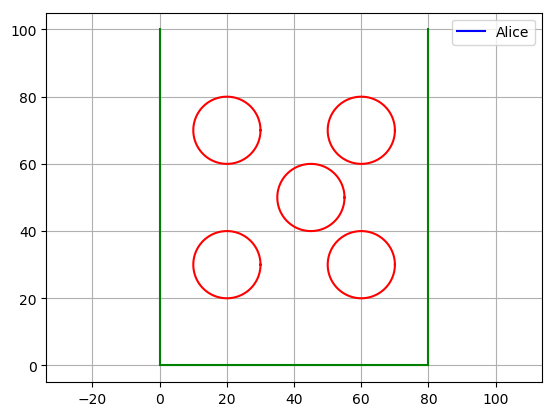

Infeasible
d_tot_actual: 0
Total energy: 0
Meeting location: (NaN, NaN)

┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP C:\Users\Ian\.julia\packages\JuMP\PbnIJ\src\nlp.jl:1283
┌ Warning: Variable value not defined for component of x_A. Check that the model was properly solved.
└ @ JuMP C:\Users\Ian\.julia\packages\JuMP\PbnIJ\src\JuMP.jl:475


In [58]:
using JuMP, PyPlot, Ipopt

# Define model, variables, constraints, objective
m = Model(solver=IpoptSolver(print_level=0))

time = 50
start = [40, 0]
finish = [40, 100]
#time_step = 36
circles = [20 30;
            60 30;
            45 50;
            20 70;
            60 70;
            ]

r = 10

ellipse = [0, 40]
r_a = 15
r_b = 5

ellipse2 = [80, 60]
r_a2 = 15
r_b2 = 5

num_circles, dim = size(circles)

@variable(m, x_A[1:2, 1:time])
@variable(m, v_A[1:2, 1:time])
@variable(m, u_A[1:2, 1:time])

# x index on east/west, y index on north/south
@constraint(m, x_A[:, 1] .== start) # Alice's initial position
@constraint(m, v_A[:, 1] .== [-10, 3]) # Alice's initial velocity 
@constraint(m, 0 .<= x_A[1, :] .<= 80   )
@constraint(m, 0 .<= x_A[2, :] .<= 101  )

# Keep path away from obstacles defined by radii from circle center
for t in 1:time
    #@NLconstraint(m, ((r_b^2)*(x_A[1, t] - ellipse[2])^2 + (r_a^2)*(x_A[2, t] - ellipse[1])^2) >= ((r_a)^2 * (r_b)^2) + 0.01  )
    #@NLconstraint(m, ((r_b2^2)*(x_A[1, t] - ellipse2[2])^2 + (r_a2^2)*(x_A[2, t] - ellipse2[1])^2) >= ((r_a2)^2 * (r_b2)^2) + 0.01 )
    for c in 1:num_circles
        @NLconstraint(m, (x_A[1,t]-circles[c,1])^2 + (x_A[2,t]-circles[c,2])^2  >= (r + r/10)^2) 
    end
end

# Dynamic equations
for t in 1:time-1
    @constraint(m, x_A[:, t+1] .== x_A[:, t] + (1/3600)*v_A[:, t]) # Alice's position    
    @constraint(m, v_A[:, t+1] .== v_A[:, t] + u_A[:, t]) # Alice's velocity
end

@constraint(m, x_A[:, time] .== finish) # final location
@constraint(m, v_A[:, time] .== [0,0]) # final velocity

# Adds up euclidian distance between each time step
#d_tot = @NLexpression(m, sum{ (x_A[1,t+1]-x_A[1,t])^2 + (x_A[2,t+1]-x_A[2,t])^2, t=1:time-1} )  

#@NLobjective(m, Min, d_tot)
@objective(m, Min, sum(u_A.^2)) # minimize total energy

# Solve
status = solve(m)
println(status)

d_tot_actual = 0
# for t in 1:time-1
#    d_tot_actual += sqrt( (getvalue(x_A[1,t+1])-getvalue(x_A[1,t]))^2 + (getvalue(x_A[2,t+1])-getvalue(x_A[2,t]))^2) 
# end

#println("d_tot: ", getvalue(d_tot))
println("d_tot_actual: ", d_tot_actual)

# Printing all values for d_tot
# for t in 1:time-1
#     println(t," ",sqrt( (getvalue(x_A[1,t+1])-getvalue(x_A[1,t]))^2 + (getvalue(x_A[2,t+1])-getvalue(x_A[2,t]))^2 ))
# end

# Output
x_A = getvalue(x_A)
println("Total energy: ", getobjectivevalue(m))
println("Meeting location: (", x_A[1,time],", ",x_A[2,time],")")

# Graph path
plot(x_A[1, :], x_A[2, :], color="blue", label="Alice")
#plot(x_A[1, time_step], x_A[2, time_step], ".", color="orange")

# Plot circle
t = range(0,stop=2pi,length=100)         # parameter that traverses the circle
for c in 1:num_circles
    plot( circles[c,1] .+ r*cos.(t), circles[c,2] .+ r*sin.(t), color="red")  # plot circle radius r with center (x1, x2)
end

rightWally = range(0, stop=100, length = 100)
rightWallx = 0*rightWally
plot(rightWallx, rightWally, color="g")

leftWallx = 0*rightWally .+ 80
plot(leftWallx, rightWally, color="g")

bottomx = range(0, stop=80, length=10)
bottomy = 0*bottomx
plot(bottomx, bottomy, color="g")

# Plot time steps
for t in 1:time
   plot(x_A[1, t], x_A[2, t], ".", color="orange")
end

#plot( ellipse[1] .+ r_a*cos.(t), ellipse[2] .+ r_b*sin.(t), label = "Ellipse", color = "green")
#plot( ellipse2[1] .+ r_a2*cos.(t), ellipse2[2] .+ r_b2*sin.(t), label = "Ellipse", color = "green")

# Formatting
axis("equal")                            # make x and y scales equal
grid("on")
legend()
;